<a href="https://colab.research.google.com/github/xinbasu/data/blob/master/%E5%9B%9E%E5%BD%92%E6%A0%91%E5%88%92%E5%88%86%E6%95%B0%E6%8D%AE%E5%88%86%E7%BB%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import probplot
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.stats import linregress
import matplotlib as mpl
from matplotlib import cm
from scipy import stats
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score ,explained_variance_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold , train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, time
from scipy.stats import pearsonr, kendalltau
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr, t
from google.colab import drive
from sklearn.tree import DecisionTreeRegressor, export_text


plt.rcParams['font.sans-serif'] = ['SimHei']  # Use SimHei font
plt.rcParams['axes.unicode_minus'] = False  # Solve the problem that minus sign '-' cannot be displayed


In [6]:
drive.mount('/content/drive')
# Load your data
data_path = "/content/drive/My Drive/20231025奶样分析/all_wide_after_qc.csv"

Mounted at /content/drive


In [7]:
data = pd.read_csv(data_path)

In [8]:

wide_df_shift_4 = data[data['milk_number'] == 3]

# Function to remove '_value' from column names
def rename_columns(df):
    # Create a new dictionary to map old names to new names where '_value' is removed
    new_column_names = {col: col.replace('_value', '') for col in df.columns}
    # Rename the columns using the new names
    df.rename(columns=new_column_names, inplace=True)

# Call the function to rename the columns
rename_columns(wide_df_shift_4)


<ipython-input-8-891b7798f278>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=new_column_names, inplace=True)


In [27]:
data_nohaigao_filtered =  wide_df_shift_4.copy()

In [28]:
# 计算 SCS_morning
data_nohaigao_filtered['SCS_morning'] = np.log2(data_nohaigao_filtered['Cells_morning'] / 100 + 1) + 3

# 计算 SCS_evening
data_nohaigao_filtered['SCS_evening'] = np.log2(data_nohaigao_filtered['Cells_evening'] / 100 + 1) + 3

# 计算 SCS_noon
data_nohaigao_filtered['SCS_noon'] = np.log2(data_nohaigao_filtered['Cells_noon'] / 100 + 1) + 3

# 计算 SCS_midnight
data_nohaigao_filtered['SCS_midnight'] = np.log2(data_nohaigao_filtered['Cells_midnight'] / 100 + 1) + 3

In [29]:
bins = [0, 1, 6, 10]  # 定义区间的边界
labels = [0, 1, 2]  # 定义每个区间对应的标签

# 使用pd.cut进行转换
data_nohaigao_filtered['parity_category'] = pd.cut(data_nohaigao_filtered['parity'], bins=bins, labels=labels, include_lowest=True)
data_nohaigao_filtered['parity_category'] = data_nohaigao_filtered['parity_category'].astype('category')

In [30]:
data_nohaigao_filtered.columns

Index(['cow_number', 'farm_number', 'milk_number', 'province',
       'cow_farmnumber', 'parity', 'DIM', 'MY', 'Fat', 'Cru.Prot', 'Fat_yield',
       'Cru.Prot_yield', 'Cells_evening', 'Cells_midnight', 'Cells_morning',
       'Cells_noon', 'Cru.Prot_ratio_evening', 'Cru.Prot_ratio_midnight',
       'Cru.Prot_ratio_morning', 'Cru.Prot_ratio_noon', 'Cru.Prot_evening',
       'Cru.Prot_midnight', 'Cru.Prot_morning', 'Cru.Prot_noon',
       'Cru.Prot_yield_ratio_evening', 'Cru.Prot_yield_ratio_midnight',
       'Cru.Prot_yield_ratio_morning', 'Cru.Prot_yield_ratio_noon',
       'Cru.Prot_yield_evening', 'Cru.Prot_yield_midnight',
       'Cru.Prot_yield_morning', 'Cru.Prot_yield_noon', 'Fat_ratio_evening',
       'Fat_ratio_midnight', 'Fat_ratio_morning', 'Fat_ratio_noon',
       'Fat_evening', 'Fat_midnight', 'Fat_morning', 'Fat_noon',
       'Fat_yield_ratio_evening', 'Fat_yield_ratio_midnight',
       'Fat_yield_ratio_morning', 'Fat_yield_ratio_noon', 'Fat_yield_evening',
       'Fat_yi

In [31]:
# 特征和目标变量
X = data_nohaigao_filtered[[
    'Cru.Prot_evening', 'Cru.Prot_midnight', 'Cru.Prot_morning', 'Cru.Prot_noon',
    'interval_evening', 'interval_midnight','interval_morning', 'interval_noon',
    'Fat_evening', 'Fat_midnight', 'Fat_morning', 'Fat_noon',
    'SCS_morning', 'SCS_evening', 'SCS_noon', 'SCS_midnight',
    'MY', 'DIM','parity_category'
]]

y = data_nohaigao_filtered[['Cru.Prot', 'Fat']]

# 创建 MinMaxScaler 实例
scaler = MinMaxScaler()

# 对特征进行标准化
X_scaled = scaler.fit_transform(X)

# 如果需要，可以将标准化后的数据转换回 DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:695: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [32]:
from sklearn.model_selection import KFold

# 初始化 KFold 对象
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 初始化存储变量
X_train_folds = []
X_test_folds = []
y_train_folds = []
y_test_folds = []

# 进行五折交叉验证
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_folds.append(X_train)
    X_test_folds.append(X_test)
    y_train_folds.append(y_train)
    y_test_folds.append(y_test)

# 可以通过访问 X_train_folds[0], X_test_folds[0], y_train_folds[0], y_test_folds[0] 来获取第一折的训练集和测试集


In [14]:

def concordance_correlation_coefficient(y_true, y_pred):
    """计算一致性相关系数"""
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    variance_true = np.var(y_true)
    variance_pred = np.var(y_pred)

    return (2 * covariance) / (variance_true + variance_pred + (mean_true - mean_pred) ** 2)

def evaluate_predictions(y_true, y_pred):
    # 输入检查
    if len(y_true) != len(y_pred):
        return "真实值和预测值的长度必须相同"

    # 转换为numpy数组以进行计算
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 计算 R^2 准确性
    r2 = r2_score(y_true, y_pred)

    # 计算 Pearson 相关系数
    pearson_corr, _ = pearsonr(y_true, y_pred)

    # 计算 MSE
    mse = mean_squared_error(y_true, y_pred)

    # 计算预测值的标准差
    pred_std = np.std(y_pred)

    # 计算一致性相关系数
    concordance_corr = concordance_correlation_coefficient(y_true, y_pred)

    # =========================
    # 分析回归线的截距和斜率
    # =========================

    # 在 y_true 和 y_pred 之间进行线性回归，拟合模型 y_pred = a + b * y_true
    # 添加常数项（截距）
    X = sm.add_constant(y_true)
    model = sm.OLS(y_pred, X)
    results = model.fit()

    # 获取截距和斜率
    a = results.params[0]  # 截距
    b = results.params[1]  # 斜率

    # 获取截距和斜率的标准误差
    a_std_err = results.bse[0]
    b_std_err = results.bse[1]

    # 获取截距和斜率的 t 值
    a_t_value = results.tvalues[0]
    b_t_value = results.tvalues[1]

    # 获取截距和斜率的 p 值
    a_p_value = results.pvalues[0]

    # 检验斜率是否显著不等于1
    # 计算 t 值和 p 值
    t_stat_b1 = (b - 1) / b_std_err
    df = len(y_true) - 2  # 自由度
    p_value_b1 = 2 * (1 - t.cdf(abs(t_stat_b1), df))

    # 将结果添加到返回的字典中
    results_dict = {
        "R2 Score": r2,
        "Pearson Correlation": pearson_corr,
        "Mean Squared Error": mse,
        "Prediction Standard Deviation": pred_std,
        "Concordance Correlation Coefficient": concordance_corr,
        "Intercept p-value (H0: a=0)": a_p_value,
        "Slope p-value (H0: b=1)": p_value_b1
    }

    return results_dict

In [33]:
# 创建一个空数据框用来存储结果
df_results4 = pd.DataFrame(columns=["R2 Score", "Pearson Correlation", "Mean Squared Error", "Prediction Standard Deviation",
                                    "Concordance Correlation Coefficient","Intercept p-value (H0: a=0)","Slope p-value (H0: b=1)"])

# 初始化存储每个模型在每一折结果的列表
m4_pro_m_results = []
m4_pro_n_results = []
m4_pro_e_results = []
m4_fat_m_results = []
m4_fat_n_results = []
m4_fat_e_results = []

# 定义训练和测试数据的合并
for i in range(5):
    x_pro_train = X_train_folds[i]
    x_pro_test = X_test_folds[i]
    y_pro_train = y_train_folds[i]
    y_pro_test = y_test_folds[i]

    x_fat_train = X_train_folds[i]
    x_fat_test = X_test_folds[i]
    y_fat_train = y_train_folds[i]
    y_fat_test = y_test_folds[i]

    pro_merged_train = X_train_folds[i]
    pro_merged_test = X_test_folds[i]

    fat_merged_train = X_train_folds[i]
    fat_merged_test = X_test_folds[i]

    # 模型参数字典
    params = {
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 4}
    ## pro
    pro_M4_m_predictions, pro_M4_m_trained_model = regression_tree_predict(
        params,
        pro_merged_train, pro_merged_test,['SCS_morning', 'MY', 'interval_morning','DIM','Cru.Prot_morning','parity_category'] ,y_pro_train['Cru.Prot']
    )
    pro_M4_n_predictions, pro_M4_n_trained_model = regression_tree_predict(
        params,
        pro_merged_train, pro_merged_test,['SCS_noon', 'MY', 'interval_noon','DIM','Cru.Prot_noon','parity_category'] ,y_pro_train['Cru.Prot']
    )
    pro_M4_e_predictions, pro_M4_e_trained_model = regression_tree_predict(
        params,
        pro_merged_train, pro_merged_test,['SCS_evening', 'MY', 'interval_evening','DIM','Cru.Prot_evening','parity_category'] ,y_pro_train['Cru.Prot']
    )

    m4_pro_m_results.append(evaluate_predictions(y_pro_test['Cru.Prot'], pro_M4_m_predictions))
    m4_pro_n_results.append(evaluate_predictions(y_pro_test['Cru.Prot'], pro_M4_n_predictions))
    m4_pro_e_results.append(evaluate_predictions(y_pro_test['Cru.Prot'], pro_M4_e_predictions))


    params_fat = {
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 1}

    ## fat
    fat_M4_m_predictions, fat_M4_m_trained_model = regression_tree_predict(
        params_fat,
        fat_merged_train, fat_merged_test, ['SCS_morning', 'MY', 'interval_morning', 'DIM', 'Fat_morning','parity_category'], y_fat_train['Fat']
    )

    fat_M4_n_predictions, fat_M4_n_trained_model = regression_tree_predict(
        params_fat,
        fat_merged_train, fat_merged_test, ['SCS_noon', 'MY', 'interval_noon', 'DIM', 'Fat_noon','parity_category'], y_fat_train['Fat']
    )

    fat_M4_e_predictions, fat_M4_e_trained_model = regression_tree_predict(
        params_fat,
        fat_merged_train, fat_merged_test, ['SCS_evening', 'MY', 'interval_evening', 'DIM', 'Fat_evening','parity_category'], y_fat_train['Fat']
    )

    m4_fat_m_results.append(evaluate_predictions(y_fat_test['Fat'], fat_M4_m_predictions))
    m4_fat_n_results.append(evaluate_predictions(y_fat_test['Fat'], fat_M4_n_predictions))
    m4_fat_e_results.append(evaluate_predictions(y_fat_test['Fat'], fat_M4_e_predictions))



# 将五折结果求平均值，并存储到数据框中
df_results4.loc['M4_pro_m_result'] = pd.DataFrame(m4_pro_m_results).mean()
df_results4.loc['M4_pro_n_result'] = pd.DataFrame(m4_pro_n_results).mean()
df_results4.loc['M4_pro_e_result'] = pd.DataFrame(m4_pro_e_results).mean()

df_results4.loc['M4_fat_m_result'] = pd.DataFrame(m4_fat_m_results).mean()
df_results4.loc['M4_fat_n_result'] = pd.DataFrame(m4_fat_n_results).mean()
df_results4.loc['M4_fat_e_result'] = pd.DataFrame(m4_fat_e_results).mean()

df_results4

,R2 Score,Pearson Correlation,Mean Squared Error,Prediction Standard Deviation,Concordance Correlation Coefficient,Intercept p-value (H0: a=0),Slope p-value (H0: b=1)
M4_pro_m_result,0.855678,0.925324,0.014127,0.292234,0.922925,2.603694e-30,0.0
M4_pro_n_result,0.839355,0.916690,0.015755,0.289773,0.913504,2.168264e-36,0.0
M4_pro_e_result,0.850021,0.922183,0.014689,0.291580,0.919691,3.020775e-31,0.0
M4_fat_m_result,0.707579,0.841575,0.132987,0.577596,0.831240,2.097031e-75,0.0
M4_fat_n_result,0.700355,0.837490,0.136387,0.573420,0.826078,2.469511e-68,0.0
M4_fat_e_result,0.689811,0.831152,0.141224,0.574065,0.820094,2.541463e-70,0.0


In [20]:
def regression_tree_predict(params, X_train, X_test, train_columns, y_train):
    # Extract model parameters
    max_depth = params.get('max_depth', 5)
    min_samples_split = params.get('min_samples_split', 2)
    min_samples_leaf = params.get('min_samples_leaf', 4)

    # Select specified columns for training and testing
    X_train_subset = X_train[train_columns]
    X_test_subset = X_test[train_columns]

    # Define regression tree model
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # Train the model
    model.fit(X_train_subset, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_subset)

    # Return the predictions and the trained model
    return y_pred, model


In [9]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}
# 初始化决策树回归模型
model = DecisionTreeRegressor(random_state=42)

# 使用五折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 使用GridSearchCV进行参数优化
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_scaled_df[['Fat_morning','SCS_morning','MY', 'interval_morning','DIM']], y['Fat'])

# 获取最佳参数和最佳分数
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# 使用最佳模型进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_scaled_df[['Fat_morning','SCS_morning','MY', 'interval_morning','DIM']])

# 计算 R^2 和相关系数
r2 = r2_score(y['Fat'], y_pred)
correlation_coefficient = np.corrcoef(y['Fat'], y_pred)[0, 1]

print(f"最佳参数: {best_params}")
print(f"最佳五折交叉验证均方误差 (MSE): {best_score:.4f}")
print(f"R^2: {r2:.4f}")
print(f"相关系数: {correlation_coefficient:.4f}")

最佳参数: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
最佳五折交叉验证均方误差 (MSE): 0.1329
R^2: 0.7327
相关系数: 0.8560


In [10]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}
# 初始化决策树回归模型
model = DecisionTreeRegressor(random_state=42)

# 使用五折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 使用GridSearchCV进行参数优化
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_scaled_df[['Cru.Prot_morning','SCS_morning','MY', 'interval_morning','DIM']], y['Cru.Prot'])

# 获取最佳参数和最佳分数
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# 使用最佳模型进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_scaled_df[['Cru.Prot_morning','SCS_morning','MY', 'interval_morning','DIM']])

# 计算 R^2 和相关系数
r2 = r2_score(y['Cru.Prot'], y_pred)
correlation_coefficient = np.corrcoef(y['Cru.Prot'], y_pred)[0, 1]

print(f"最佳参数: {best_params}")
print(f"最佳五折交叉验证均方误差 (MSE): {best_score:.4f}")
print(f"R^2: {r2:.4f}")
print(f"相关系数: {correlation_coefficient:.4f}")

最佳参数: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
最佳五折交叉验证均方误差 (MSE): 0.0141
R^2: 0.8719
相关系数: 0.9338


In [ ]:
# 使用五折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 创建模型并使用最佳参数
best_model = DecisionTreeRegressor(**best_params, random_state=42)

# 进行五折交叉验证以评估优化后的模型
mse_scores = []
r2_scores = []
correlation_coefficients = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    correlation, _ = pearsonr(y_test, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)
    correlation_coefficients.append(correlation)

mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
mean_corr = np.mean(correlation_coefficients)
std_corr = np.std(correlation_coefficients)

print(f"优化后的五折交叉验证均方误差 (MSE): {mean_mse:.4f} ± {std_mse:.4f}")
print(f"优化后的五折交叉验证R²分数: {mean_r2:.4f} ± {std_r2:.4f}")
print(f"优化后的五折交叉验证相关系数: {mean_corr:.4f} ± {std_corr:.4f}")


优化后的五折交叉验证均方误差 (MSE): 48.3568 ± 1.0914
优化后的五折交叉验证R²分数: 0.9512 ± 0.0019
优化后的五折交叉验证相关系数: 0.9754 ± 0.0010


In [ ]:
# 输出决策树结构
tree_rules = export_text(best_model, feature_names=list(X.columns))

In [ ]:
print(tree_rules)

|--- MY <= 39.22
|   |--- MY <= 28.78
|   |   |--- MY <= 21.72
|   |   |   |--- MY <= 16.91
|   |   |   |   |--- MY <= 11.98
|   |   |   |   |   |--- MY <= 9.15
|   |   |   |   |   |   |--- DIM <= 219.00
|   |   |   |   |   |   |   |--- parity_modified <= 0.50
|   |   |   |   |   |   |   |   |--- value: [32.48]
|   |   |   |   |   |   |   |--- parity_modified >  0.50
|   |   |   |   |   |   |   |   |--- value: [40.41]
|   |   |   |   |   |   |--- DIM >  219.00
|   |   |   |   |   |   |   |--- Cells_value_score <= 4.91
|   |   |   |   |   |   |   |   |--- value: [29.73]
|   |   |   |   |   |   |   |--- Cells_value_score >  4.91
|   |   |   |   |   |   |   |   |--- value: [19.05]
|   |   |   |   |   |--- MY >  9.15
|   |   |   |   |   |   |--- Fat_yield_value <= 17.45
|   |   |   |   |   |   |   |--- DIM <= 17.50
|   |   |   |   |   |   |   |   |--- value: [33.76]
|   |   |   |   |   |   |   |--- DIM >  17.50
|   |   |   |   |   |   |   |   |--- MY <= 10.93
|   |   |   |   |   |   |   | 

In [ ]:
# 统计 Cells_value_score 作为分裂点出现的次数
split_feature = "Cells_value_score"
split_points = []

# 遍历每一行，查找分裂点
for line in tree_rules.split("\n"):
    if split_feature in line:
        # 提取出分裂点的数值
        parts = line.split()
        for part in parts:
            if part.replace('.', '', 1).isdigit():  # 检查是否为数值
                split_points.append(float(part))
                break

# 统计每个分裂点的出现次数
from collections import Counter
split_count = Counter(split_points)

# 打印统计结果
for point, count in split_count.items():
    print(f"Split point {point}: {count} times")

Split point 3.58: 2 times
Split point 4.31: 2 times
Split point 5.78: 2 times
Split point 3.33: 2 times
Split point 3.95: 2 times
Split point 3.85: 2 times
Split point 3.47: 2 times
Split point 4.24: 2 times
Split point 4.06: 2 times
Split point 4.52: 2 times
Split point 3.56: 4 times
Split point 4.48: 2 times
Split point 5.85: 2 times
Split point 3.49: 2 times
Split point 3.28: 2 times
Split point 3.64: 2 times
Split point 3.38: 2 times
Split point 3.94: 2 times
Split point 3.39: 2 times
Split point 3.24: 2 times
Split point 3.46: 2 times


In [ ]:
# 查找 parity_modified 分裂节点的阈值
parity_index = list(X.columns).index('parity_modified')

# 获取决策树的特征索引和阈值
tree = best_model.tree_
feature = tree.feature
threshold = tree.threshold

# 找到与 parity_modified 对应的特征的所有分裂节点的阈值
parity_thresholds = threshold[feature == parity_index]

# 打印 parity_modified 的断点
print("parity_modified 的分裂节点阈值（断点）：", parity_thresholds)

parity_modified 的分裂节点阈值（断点）： [0.5 2.  2.5 1.  0.5 1.5 3.5 2.5 0.5 3.5 2.5 0.5 1.5 3.5]


In [ ]:
# 获取树的属性
tree = best_model.tree_

# 获取特征名称列表和特征索引
feature_names = X.columns
feature_index = np.where(feature_names == 'DIM')[0][0]

# 提取所有与 DIM 相关的分裂点
split_points = []

for i in range(tree.node_count):
    if tree.feature[i] == feature_index:
        split_points.append(tree.threshold[i])

print(f"DIM 的分裂点: {split_points}")

DIM 的分裂点: [219.0, 17.5, 316.5, 87.0, 312.5, 247.0, 159.0, 35.5, 317.0, 11.0, 171.0, 225.0, 148.0, 164.5, 258.5, 87.5, 235.5, 38.0, 167.5, 50.5, 291.5, 207.0, 14.5, 212.0, 105.0, 71.0, 45.0, 47.0, 212.5, 23.5, 32.0, 65.5, 29.0, 25.0, 52.5, 56.5, 35.0, 86.0, 33.0, 26.5, 122.0, 28.5, 108.0, 26.0, 28.5, 179.0, 336.5, 56.0, 38.0, 51.0, 40.0, 80.0, 40.0, 20.5, 44.5, 42.0, 104.5, 40.5, 122.0, 72.0]


In [ ]:
# 获取树的属性
tree = best_model.tree_

# 获取特征名称列表和特征索引
feature_names = X.columns
feature_index = np.where(feature_names == 'Cells_value_score')[0][0]

# 提取所有与 DIM 相关的分裂点
split_points = []

for i in range(tree.node_count):
    if tree.feature[i] == feature_index:
        split_points.append(tree.threshold[i])

print(f"DIM 的分裂点: {split_points}")

DIM 的分裂点: [4.912322759628296, 3.2799662351608276, 3.4275962114334106, 3.4589641094207764, 3.665565848350525, 3.8395992517471313, 3.469801425933838, 6.329335689544678, 4.386808395385742, 3.327675938606262, 4.646096467971802, 3.7320727109909058, 3.333378314971924, 3.981477975845337, 3.2139103412628174, 5.351156949996948, 6.6334068775177, 3.3035526275634766, 3.6254807710647583, 3.801513433456421, 4.3860485553741455, 4.589373350143433, 4.286578178405762, 3.5359156131744385, 3.327675938606262, 5.249080657958984, 3.327401041984558, 4.590049982070923, 3.2325432300567627, 4.081266283988953, 3.53481662273407, 4.313009262084961, 5.544149160385132, 3.448813796043396, 3.316041111946106, 4.639549970626831, 3.214071273803711, 4.572447299957275, 3.274957776069641, 3.619882345199585, 5.502484321594238, 3.8786609172821045, 3.384039282798767, 3.859306812286377, 3.7865902185440063, 3.223128080368042]


In [ ]:
# 假设你的数据框是 `data`，且目标变量为 `Fat`
# 只选择 `DIM` 作为特征
#X = data[['Fat_value', 'DIM']]
X = data[[ 'Cells_value_score']]
y = data['Cru.Prot_yield']

# 使用五折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 初始化决策树回归模型
#model = DecisionTreeRegressor(max_depth=5, random_state=42)  # 例如限制最大深度为2
model = DecisionTreeRegressor(max_leaf_nodes=7, random_state=42)  # 或者限制最多3个叶节点
mse_scores = []
r2_scores = []
correlation_coefficients = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    correlation, _ = pearsonr(y_test, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)
    correlation_coefficients.append(correlation)

mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
mean_corr = np.mean(correlation_coefficients)
std_corr = np.std(correlation_coefficients)

print(f"仅使用 DIM 的五折交叉验证均方误差 (MSE): {mean_mse:.4f} ± {std_mse:.4f}")
print(f"仅使用 DIM 的五折交叉验证R²分数: {mean_r2:.4f} ± {std_r2:.4f}")
print(f"仅使用 DIM 的五折交叉验证相关系数: {mean_corr:.4f} ± {std_corr:.4f}")
# 获取树的属性
tree = model.tree_

# 获取特征名称列表和特征索引
feature_names = X.columns
feature_index = np.where(feature_names == 'Cells_value_score')[0][0]

# 提取所有与 DIM 相关的分裂点
split_points = []

for i in range(tree.node_count):
    if tree.feature[i] == feature_index:
        split_points.append(tree.threshold[i])

print(f"DIM 的分裂点: {split_points}")

仅使用 DIM 的五折交叉验证均方误差 (MSE): 951.6624 ± 30.8407
仅使用 DIM 的五折交叉验证R²分数: 0.0413 ± 0.0096
仅使用 DIM 的五折交叉验证相关系数: 0.2039 ± 0.0221
DIM 的分裂点: [3.4168297052383423, 3.211008906364441, 3.835918426513672, 3.130915880203247, 3.3161340951919556, 7.775313854217529]


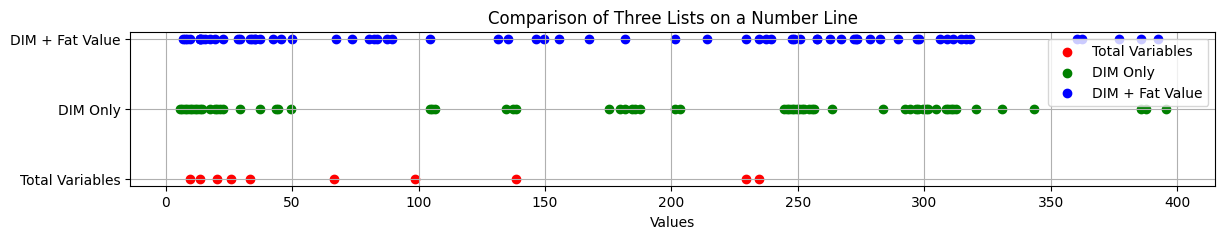

In [ ]:
# 数据定义
total_variables = [13.5, 98.5, 66.5, 26.0, 33.5, 234.5, 138.5, 20.5, 9.5, 229.5]
dim_only = [245.5, 14.5, 9.5, 5.5, 7.5, 6.5, 8.5, 10.5, 12.5, 11.5, 13.5, 134.5, 37.5, 20.5, 19.5, 17.5, 22.5, 21.5, 29.5, 104.5, 44.5, 43.5, 49.5, 105.5, 106.5, 185.5, 179.5, 138.5, 137.5, 175.5, 184.5, 181.5, 244.5, 201.5, 187.5, 203.5, 263.5, 247.5, 246.5, 250.5, 248.5, 249.5, 252.5, 251.5, 255.5, 254.5, 256.5, 310.5, 300.5, 296.5, 292.5, 283.5, 294.5, 297.5, 299.5, 301.5, 308.5, 304.5, 309.5, 312.5, 311.5, 385.5, 330.5, 320.5, 343.5, 387.5, 395.5]
dim_fat_value = [251.0, 87.5, 50.0, 248.5, 83.5, 80.5, 306.0, 34.0, 214.0, 42.5, 257.5, 234.5, 22.5, 45.5, 316.5, 311.5, 237.5, 35.5, 362.5, 13.5, 181.5, 146.5, 385.5, 247.5, 33.5, 67.5, 262.5, 273.5, 167.5, 13.5, 89.5, 82.5, 273.0, 14.5, 7.0, 267.0, 282.5, 149.5, 35.5, 17.5, 272.0, 257.5, 289.5, 29.5, 104.5, 377.0, 298.0, 392.5, 201.5, 19.5, 131.5, 360.5, 135.5, 15.5, 13.5, 8.5, 37.5, 73.5, 309.0, 297.0, 318.0, 239.5, 155.5, 9.5, 7.5, 229.5, 28.5, 278.5, 314.5]

# 创建数轴图
plt.figure(figsize=(14, 2))

# 绘制每个列表的点在数轴上
plt.scatter(total_variables, [1]*len(total_variables), color='red', label='Total Variables')
plt.scatter(dim_only, [2]*len(dim_only), color='green', label='DIM Only')
plt.scatter(dim_fat_value, [3]*len(dim_fat_value), color='blue', label='DIM + Fat Value')

# 设置数轴标签
plt.yticks([1, 2, 3], ['Total Variables', 'DIM Only', 'DIM + Fat Value'])
plt.xlabel('Values')
plt.title('Comparison of Three Lists on a Number Line')
plt.grid(True)
plt.legend(loc='upper right')

# 显示图形
plt.show()


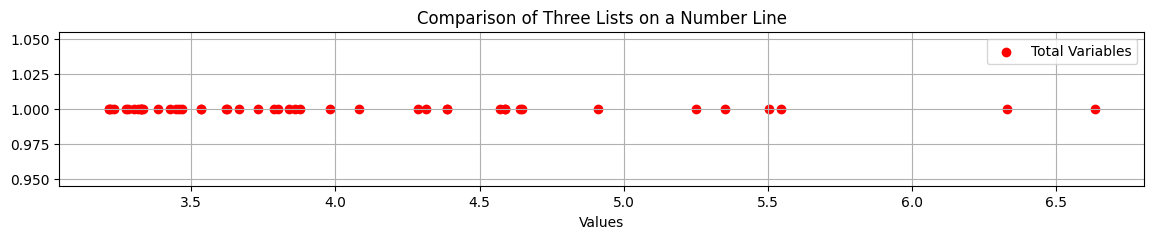

In [ ]:
total_variables = [3.2139103412628174,3.214071273803711,3.223128080368042,3.2325432300567627,3.274957776069641,3.2799662351608276,3.3035526275634766,3.316041111946106,3.327401041984558,3.327675938606262,3.327675938606262,3.333378314971924,3.384039282798767,3.4275962114334106,3.448813796043396,3.4589641094207764,3.469801425933838,3.53481662273407,3.5359156131744385,3.619882345199585,3.6254807710647583,3.665565848350525,3.7320727109909058,3.7865902185440063,3.801513433456421,3.8395992517471313,3.859306812286377,3.8786609172821045,3.981477975845337,4.081266283988953,4.286578178405762,4.313009262084961,4.3860485553741455,4.386808395385742,4.572447299957275,4.589373350143433,4.590049982070923,4.639549970626831,4.646096467971802,4.912322759628296,5.249080657958984,5.351156949996948,5.502484321594238,5.544149160385132,6.329335689544678,6.6334068775177]
# 创建数轴图
plt.figure(figsize=(14, 2))

# 绘制每个列表的点在数轴上
plt.scatter(total_variables, [1]*len(total_variables), color='red', label='Total Variables')
plt.xlabel('Values')
plt.title('Comparison of Three Lists on a Number Line')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()


In [ ]:
# 初始化线性回归模型
model = LinearRegression()

# 使用交叉验证预测
y_pred = cross_val_predict(model, X, y, cv=5)

# 计算均方误差 (MSE)
mse = mean_squared_error(y, y_pred)

# 计算 R² 分数
r2 = r2_score(y, y_pred)

# 计算相关系数
correlation_matrix = np.corrcoef(y, y_pred)
correlation_coefficient = correlation_matrix[0, 1]

print(f"五折交叉验证的均方误差 (MSE): {mse:.4f}")
print(f"五折交叉验证的 R² 分数: {r2:.4f}")
print(f"五折交叉验证的相关系数: {correlation_coefficient:.4f}")

五折交叉验证的均方误差 (MSE): 0.1565
五折交叉验证的 R² 分数: 0.6530
五折交叉验证的相关系数: 0.8081
